In [92]:
import numpy as np
import pandas as pd
import torch
import os
import json

from sentence_transformers import SentenceTransformer
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer

In [2]:
df = pd.read_csv('../../data/df_all.csv', low_memory=False)
df.head()

,Unnamed: 0,question,id,answer,count,cluster,sentiment
0,0,Что вы сможете использовать в своей работе?,10106.0,"формулировать проблему, 5 поче",1.0,NaN,NaN
1,1,Что вы сможете использовать в своей работе?,10106.0,поиск потерь,1.0,NaN,NaN
2,2,Что вы сможете использовать в своей работе?,10106.0,правило 5 «почему» :),1.0,NaN,NaN
3,3,Что вы сможете использовать в своей работе?,10106.0,умение работать в команде,1.0,NaN,NaN
4,4,Что вы сможете использовать в своей работе?,10106.0,картирование и анализ,1.0,NaN,NaN


In [124]:
questions = df["question"].unique()

In [ ]:
tokenizer = BertTokenizer.from_pretrained('.tmp/rubert_cased_L-12_H-768_A-12_pt')
q_model = BertModel.from_pretrained('.tmp/rubert_cased_L-12_H-768_A-12_pt', output_hidden_states = True)

In [125]:
q_model = SentenceTransformer('jgammack/distilbert-base-mean-pooling')
q_embeddings = q_model.encode(questions)
print(q_embeddings)

[[-0.06247966  0.01212256  0.10460092 ... -0.16894348  0.6768306
   0.06506314]
 [ 0.0583237  -0.08596297  0.04500069 ... -0.2982413   0.57117265
  -0.01411345]
 [ 0.05087584 -0.05758586 -0.06082392 ... -0.23370156  0.58796877
   0.08195261]
 ...
 [-0.12949234 -0.08348583 -0.05355816 ... -0.37577876  0.67229015
   0.03970782]
 [ 0.0615953  -0.1906346  -0.17081176 ... -0.36970872  0.5594226
   0.00859676]
 [-0.04563662 -0.06394088  0.10995453 ... -0.16311558  0.5322874
   0.2761398 ]]


In [141]:
q_embeddings.shape

(390, 768)

In [146]:
pca_15 = PCA(n_components=15, random_state=42)
q_emb_15d = pca_15.fit_transform(q_embeddings)
q_emb_15d

array([[-0.09340184, -0.2629835 ,  0.06275763, ..., -0.12626234,
        -0.05341041,  0.46223262],
       [ 0.1603386 , -0.01309301,  0.40196988, ...,  0.00679035,
        -0.3847411 ,  0.02541305],
       [ 0.9938723 , -0.988717  , -0.24709779, ..., -0.01837536,
         0.02682607, -0.20429923],
       ...,
       [ 1.1898459 , -0.02337114,  1.0967387 , ...,  0.09929209,
        -0.0180727 ,  0.72628224],
       [ 3.8337634 ,  0.23576982,  1.1131369 , ...,  0.6717896 ,
        -0.05909942,  0.08768833],
       [ 0.23706178, -0.12935089, -0.2228837 , ...,  0.03335047,
         0.0972172 , -0.03243962]], dtype=float32)

In [147]:
q_clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=0.6, affinity='cosine', linkage='average').fit(q_emb_15d)

/home/alexander/.local/share/virtualenvs/Hakaton-08-09-2023-I04-RJmn/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1005: FutureWarning:

Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead



In [148]:
pca_2 = PCA(n_components=2, random_state=42)
q_emb_2d = pd.DataFrame(pca_2.fit_transform(q_embeddings), columns=['x1', 'x2'])
q_emb_2d['label'] = q_clustering.labels_
print(q_emb_2d['label'].nunique())
q_emb_15d = pd.DataFrame(pca_15.fit_transform(q_embeddings))
q_emb_15d['label'] = q_clustering.labels_


35


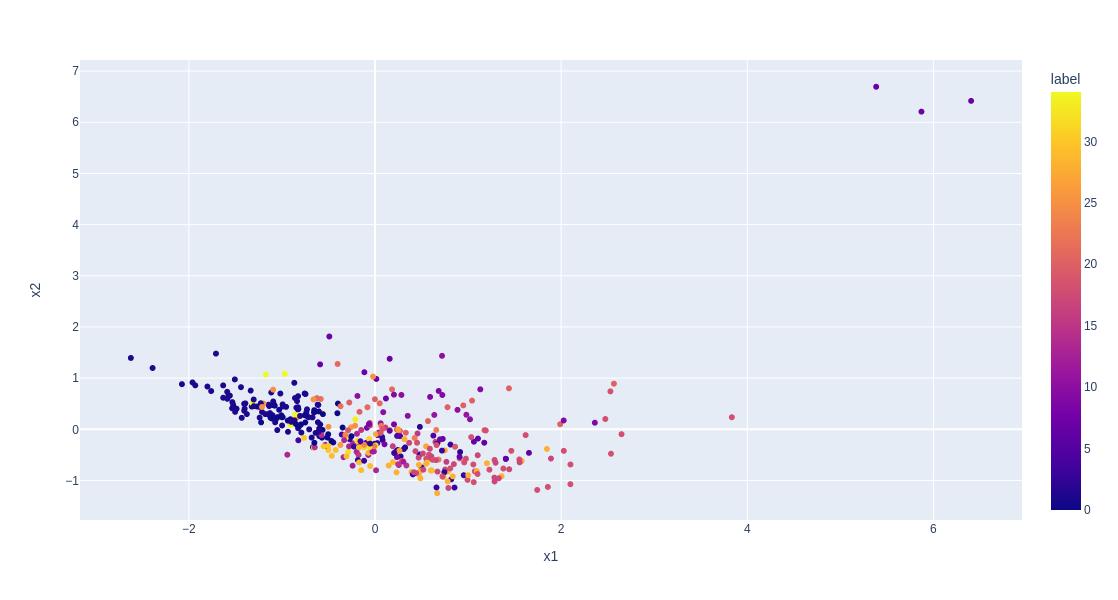

In [149]:
import plotly.express as px
fig = px.scatter(q_emb_2d, x='x1', y='x2', color='label', width=800, height=600)
fig.show()

In [150]:
def show_examples(data, emb, cluster, n):
    for i, a in enumerate(data[emb['label'] == cluster]):
        print(i, a)

def cluster_len(data, emb, cluster, n):
    return len(data[emb['label'] == cluster])

In [151]:
s = 0
max_, min_=  0, 100000
for i in range(32):
    show_examples(questions, q_emb_15d, cluster=i, n=3)
    print()

0 Опишите одним-двумя словами что было самым ценным для вас за этот день?
1 Основная мысль по результатам конференции
2 Что бы вы хотели пожелать своим коллегам-выпускникам?
3 Какие инструменты мотивации вы используете в работе?
4 Какие ключевые посылы по итогам выступления Ужакиной Ю.Б. Вы для себя отметили?
5 Для чего внедрять визуальный 
контроль рабочего пространства?
6 Что было для вас самым ценным за два дня сессии? Опишите 1-2 словами
7 Какие направления/темы обучения вы считаете наиболее актуальными?
8 9.Какие компетенции, мастер-классы или темы можно было добавить?
9 КАКИЕ ПРОБЛЕМЫ МОГУТ БЫТЬ В КОММУНИКАЦИИ
10 Какие направления работы, на ваш взгляд, обязательно должны быть в деятельности Совета молодежи?
11 Что является главным «стоп»-фактором для запуска Новых бизнесов?
12 Какие ключевые темы вы бы хотели обсудить на Стратегической сессии?
13 Какое самое яркое карьерное событие событие вы посещали?
14 Какие проекты за рамками обозначенных направлений сейчас актуальны для мол

In [56]:
q_emb_15d

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,label
0,-2.938667,0.377932,-0.316718,-1.457457,0.722606,-0.308296,1.278183,0.074194,0.423987,-0.999091,-1.250461,-0.451905,-0.843797,0.618425,-0.485485,0
1,2.038786,-3.299941,-0.106819,2.151040,0.324771,-0.664926,1.032394,-0.691579,-0.055823,0.235078,-1.500464,0.399001,0.904946,-0.362846,0.265482,7
2,-3.684312,-0.154793,1.072141,0.957777,0.810555,-0.170520,0.086704,0.075763,1.229377,-1.192209,0.386081,-0.477426,0.986420,1.423658,-0.760304,0
3,3.285359,1.292310,2.069737,0.839229,2.148012,-2.773433,-0.999208,-0.717018,-1.059796,-1.627880,-0.169549,-0.213606,0.067605,-0.138708,0.253426,5
4,-1.767925,-1.150854,0.793820,1.013768,-0.463881,0.483971,-1.117896,0.341811,-0.530015,0.629835,-0.734396,0.441645,-0.322630,-1.100261,0.936779,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,-0.032754,-1.041359,0.445065,-2.223379,-0.954277,0.305072,-0.361467,-0.025325,0.162202,-0.509767,0.647909,-0.167798,-1.080518,-0.519304,-0.048117,4
386,-0.233949,-1.200536,0.778047,-2.299959,-1.132387,0.235616,-0.282736,0.396029,1.020769,-0.197387,1.580749,-0.085619,-0.427856,-0.108049,-0.313067,4
387,-3.358770,-0.474047,0.459104,-0.771082,-0.897243,-0.608492,1.419913,0.274290,0.630066,-0.720754,-0.121225,-0.012556,-0.728210,-0.021220,-0.303010,0
388,-4.474088,-1.480140,0.025894,1.424687,-0.919245,-0.416948,0.969562,0.137912,0.496200,-0.877631,0.423448,0.309619,-1.002561,-0.680417,-0.052416,0


In [ ]:
questions